Wavelet Block Thresholding
==========================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour presents block thresholding methods,
that makes use of the structure of wavelet coefficients of natural images to perform denoising.
Theoretical properties of block thresholding were investigated
in [CaiSilv](#biblio) [Cai99](#biblio) [HallKerkPic99](#biblio)

In [1]:
options(repr.plot.width=4, repr.plot.height=4)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)

source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")

Loading required package: plyr
Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



Generating a Noisy Image
------------------------
Here we use an additive Gaussian noise.


Size of the image of $N=n \times n$ pixels.

In [2]:
n <- 256

First we load an image $f_0 \in \RR^N$.

In [3]:
f0 <- rescale(load_image("nt_toolbox/data/boat.png", n))

Display it.

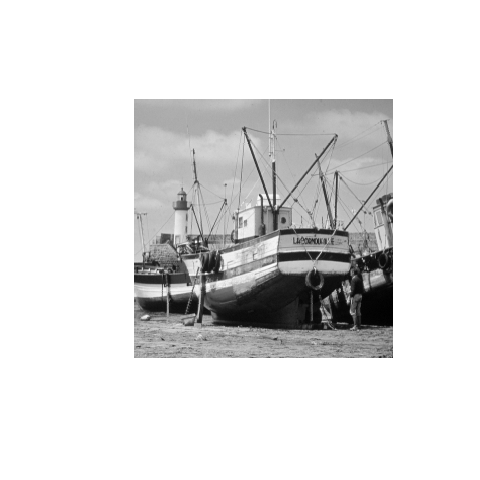

In [4]:
imageplot(f0)

Noise level.

In [5]:
sigma <- .08

Generate a noisy image $f=f_0+\epsilon$ where $\epsilon \sim
\Nn(0,\si^2\text{Id}_N)$.

In [6]:
f <- f0 + sigma*as.cimg(rnorm(n**2))

Display it.

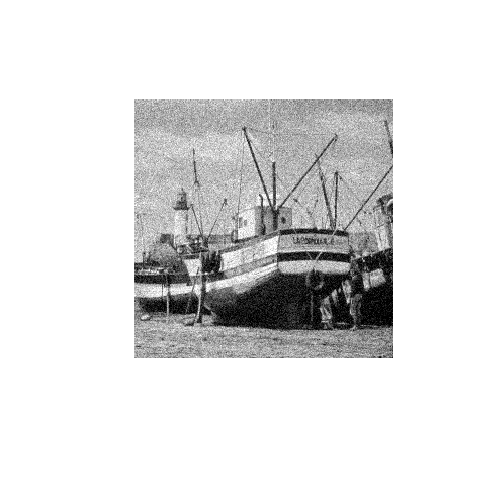

In [7]:
imageplot(clamp(f))

Orthogonal Wavelet Thresholding
-------------------------------
We first consider the traditional
wavelet thresholding method.


Parameters for the orthogonal wavelet transform.

In [8]:
Jmin <- 4

Shortcuts for the foward and backward wavelet transforms.

In [9]:
source("nt_toolbox/perform_wavelet_transf.R")

wav  <- function(f){ perform_wavelet_transf(f, Jmin, +1) }
iwav <- function(fw){ perform_wavelet_transf(fw, Jmin, -1) }

Display the original set of noisy coefficients.

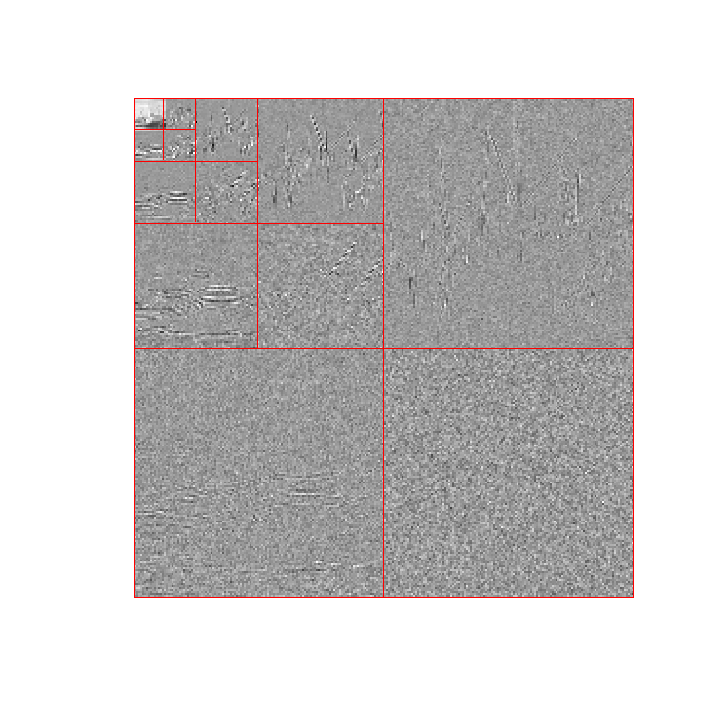

In [10]:
options(repr.plot.width=6, repr.plot.height=6)

plot_wavelet(wav(f), Jmin)

Denoting $\Ww$ and $\Ww^*$ the forward and backward wavelet
transform, wavelet thresholding $\tilde f$ is defined as

$$ \tilde f = \Ww^* \circ \theta_T \circ \Ww(f) $$

where $T>0$ is the threshold, that should be adapted to the noise
level.


The thresholding operator is applied component-wise

$$ \th_T(x)_i = \psi_T(x_i) x_i $$

where $\psi_T$ is an atenuation fonction. In this tour, we use the James
Stein (JS) attenuation:

$$ \psi_T(s) = \max\pa{ 0, 1-\frac{T^2}{s^2} } $$

In [11]:
psi <- function (s,T){
    d <- dim(s)
    s0 <- 1 - T**2/vapply(as.vector(abs(s)**2), function(a){max(a,1e-9)}, double(1))
    s0 <- vapply(as.vector(s0), function(a){max(a,0)}, double(1))
    if (max(d,0)!=0){s0 <- array(s0, d)}
    return(s0)
}

Display the thresholding function $\th_T$.

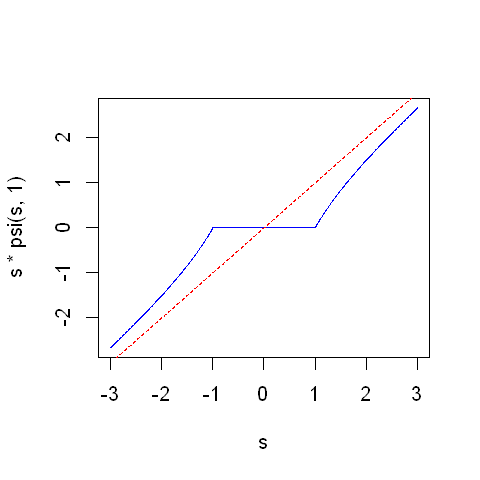

In [12]:
options(repr.plot.width=4, repr.plot.height=4)

s <- seq(-3, 3, length=1024)

plot(s, s*psi(s,1), "l", col="blue")
lines(s, s, lty=2, col="red")

Thresholding operator.

In [13]:
theta <- function(x,T){ psi(x, T)*x }
ThreshWav <- function(f,T){ iwav(theta(wav(f), T)) }

Test the thresholding.

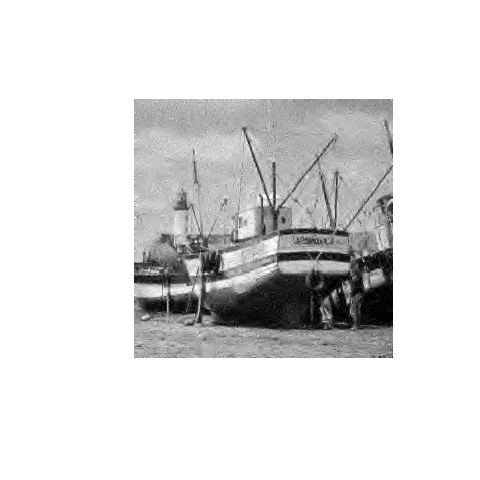

In [14]:
T <- 1.5*sigma

options(repr.plot.width=4, repr.plot.height=4)
imageplot(clamp(ThreshWav(f, T)))

__Exercise 1__

Display the evolution of the denoising SNR when $T$ varies.
Store in $f_{Thresh}$ the optimal denoising result.

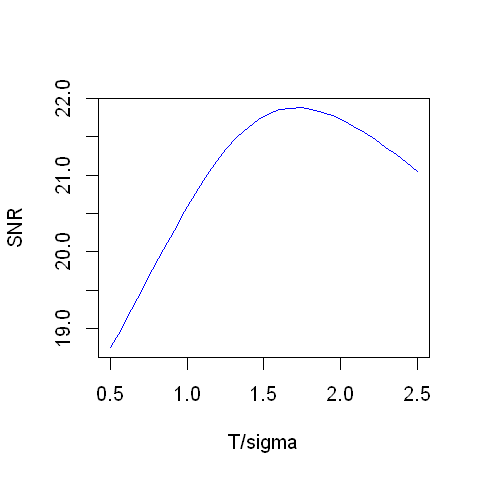

In [15]:
options(repr.plot.width=4, repr.plot.height=4)

source("nt_solutions/denoisingwav_4_block/exo1.R")

In [16]:
## Insert your code here.

Display the optimal thresolding.

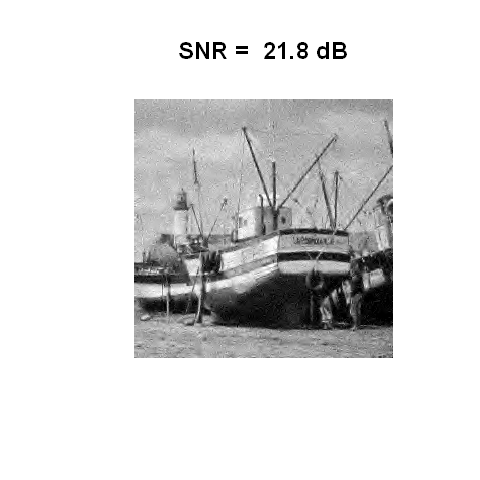

In [17]:
imageplot(clamp(fThresh), paste("SNR = ", round(snr(f0, fThresh),1), "dB"))

Block Thresholding Operator
---------------------------
A block thresholding operator of coefficients $x=(x_i)_{i=1}^P \in \RR^P$ is defined
using a partition $B$ into a set of blocks $b$

$$ \{1,\ldots,P\} = \bigcup_{b \in B} b. $$
Its definition reads

$$ \forall i \in b, \quad
      \theta_T(x)_i = \psi_T\left( \norm{x_b}_2 \right) x_i $$
      
where $ x_b = (x_j)_{j \in B} \in \RR^{\abs{b}} $.
One thus thresholds the $\ell^2$ norm (the energy) of each block rather
than each coefficient independently.


For image-based thresholding, we use a partition in square blocks of
equal size $w \times w$.


The block size $w$.

In [18]:
w <- 4
n <- 256

Compute indexing of the blocks.

In [19]:
source("nt_toolbox/meshgrid.R")
grid <- meshgrid_4d(seq(1, n-w+1, w), seq(1, n-w+1, w), seq(0, w-1), seq(0, w-1))
X <- grid$X ; Y <- grid$Y ; dX <- grid$Z ; dY <- grid$S
I <- (X + dX-1) + (Y + dY-1)*n

for (k in 1:(n%/%w)){
    for (l in 1:(n%/%w)){
        I[k,l,,] <- t(I[k,l,,])
    }
}

Block extraction operator. It returns the set $ \{x_b\}_{b \in B} $
of block-partitioned coefficients.

In [20]:
block <- function(x){ array(as.vector(x)[I+1], dim(I)) }

Block reconstruction operator.

In [21]:
assign <- function(M,I,H){
    M_temp <- as.array(M, dim(I))
    M_temp[I+1] <- H
    return(matrix(M_temp, c(n,n), byrow=FALSE))
}

iblock <- function(H){ assign(matrix(rep(0,n*n), c(n,n)), I, H)}

Check that block extraction / reconstruction gives perfect
reconstruction.

In [22]:
print( paste("Should be 0:", norm(as.matrix(f) - iblock(block(f)))) )

[1] "Should be 0: 0"


Compute the average energy of each block, and duplicate.

In [23]:
energy <- function(H){
    H_tmp <- H
    for (i in 1:n%/%w){
        for (j in 1:n%/%w){
            H_tmp[i,j,,] <- sqrt( mean(H_tmp[i,j,,]**2) )
        }
    }
    return(H_tmp)
}

Block thresholding operator.

In [24]:
Thresh <- function(H,T){ psi(energy(H), T)*H }
ThreshBlock <- function(x,T){ iblock(Thresh(block(x), T)) }

__Exercise 2__

Test the effect of block thresholding on the image $f_0$ itself, for increasing value of $T$.
Of course directly thresholding the image has no interest, this is just
to vizualize the effect.

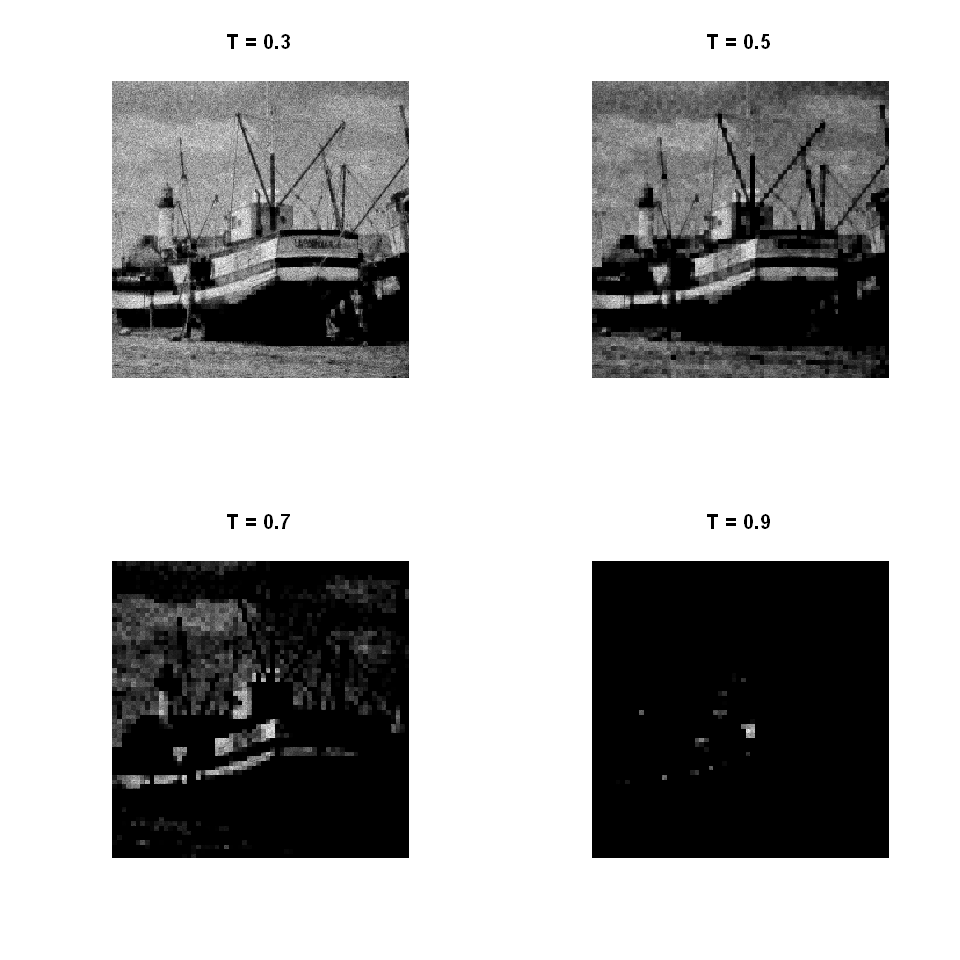

In [25]:
options(repr.plot.width=8, repr.plot.height=8)

source("nt_solutions/denoisingwav_4_block/exo2.R")

In [26]:
## Insert your code here.

Orthogonal Wavelet Block Thresholding
-------------------------------------
Wavelet coefficients of natural images are not independant one from each
other. One can thus improve the denoising results by thresholding block
of coefficients togethers. Block thresholding is only efficient when
used as a soft thresholder. Here we use a Stein soft thresholder.


Display the thresholded coefficients for a threshold value $T$ proportional to the noise level $\si$.

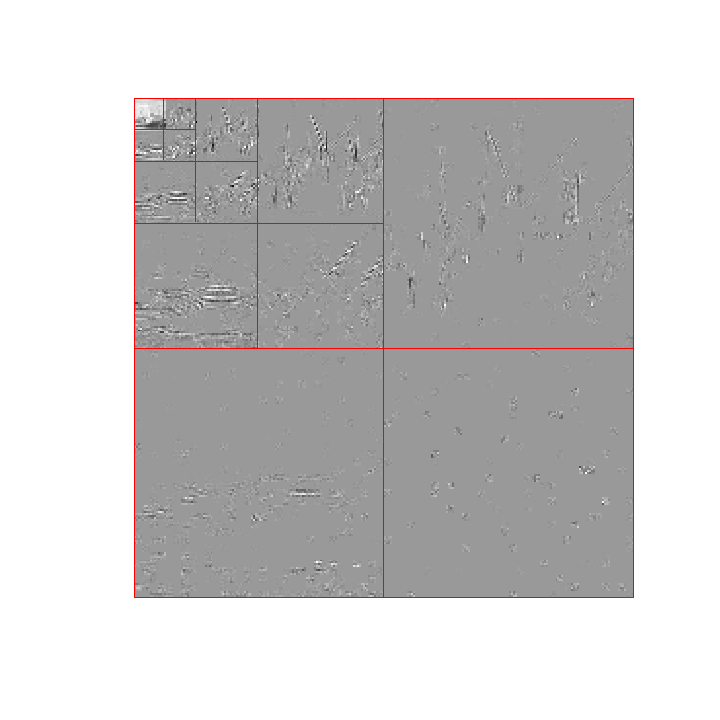

In [27]:
T <- 1.25*sigma

options(repr.plot.width=6, repr.plot.height=6)
plot_wavelet(ThreshBlock(wav(f), T), Jmin)

Define the wavelet block thresholding operator.

In [28]:
ThreshWav <- function(f, T){ iwav(ThreshBlock(wav(f), T)) }

Test the thresholding.

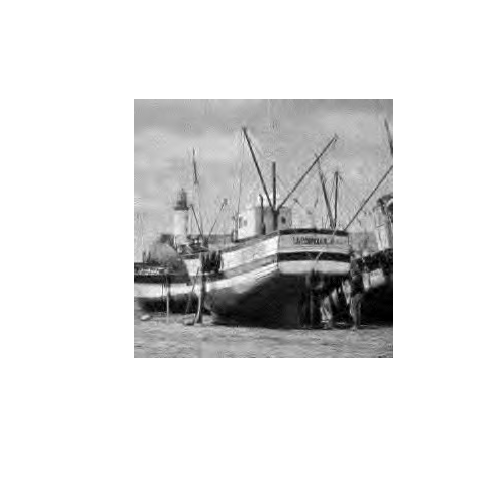

In [29]:
options(repr.plot.width=4, repr.plot.height=4)

imageplot(clamp(ThreshWav(f, T)))

__Exercise 3__

Display the evolution of the denoising SNR when $T$ varies.
Store the optimal denoising result in $f_{Block}$.

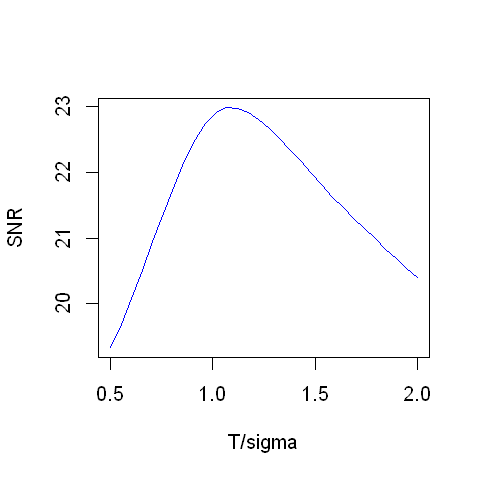

In [30]:
source("nt_solutions/denoisingwav_4_block/exo3.R")

In [31]:
## Insert your code here.

Display the result.

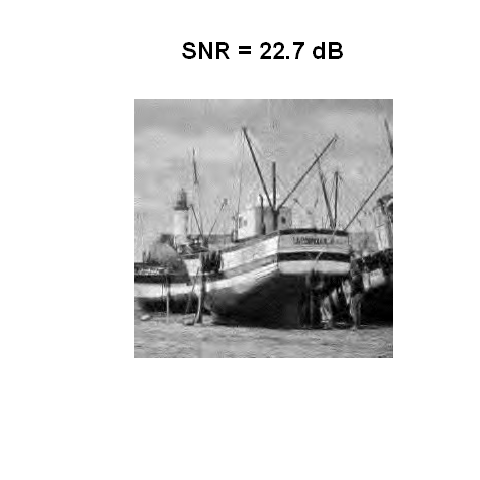

In [32]:
imageplot(clamp(fBlock), paste("SNR =", round(snr(f0, fBlock),1), "dB"))

Translation invariant Block Thresholding
----------------------------------------
Block thresholding can also be applied to a translation invariant wavelet
transform. It gives state of the art denoising results.



Shortcuts for the foward and backward translation invariant wavelet transforms.

In [33]:
wav  <- function(f){ perform_wavelet_transf(f, Jmin, + 1, ti=1) }
iwav <- function(fw){ perform_wavelet_transf(fw, Jmin, -1, ti=1) }

Foward wavelet transform.

In [34]:
fw <- wav(f)
n <-  256
#dim(fw)[1]

Compute indexing of the blocks.

In [35]:
source("nt_toolbox/meshgrid.R")
grid <- meshgrid_5d(seq(1, n-w+1, w), seq(1, dim(fw)[1]), seq(1, n-w+1, w), seq(0, w-1), seq(0, w-1))
X <- grid$X ; J <- grid$Y ; Y <- grid$Z ; dX <- grid$S ; dY <- grid$U
I <- (X + dX-1) + (Y + dY-1)*n + (J-1)*n**2
for (k in 1:(n%/%w)){
    for (l in 1:(n%/%w)){
        for (m in 1:dim(fw)[1]){
            I[m,k,l,,] <- t(I[m,k,l,,])
        }
    }
}

Forward and backward extraction operators.

In [36]:
block <- function(x){ array(as.vector(aperm(x,c(3,2,1)))[I+1], dim(I)) }


assign <- function(M,I,H){
    M_temp <- as.vector(M)
    M_temp[I+1] <- H

    idx <- 0
    for (i in 1:dim(M)[1]){
        for (j in 1:dim(M)[2]){
            for (k in 1:dim(M)[3]){
                idx <- idx + 1
                M[i,j,k] <- M_temp[ idx ]
            }
        }
    }
    return(M)
}


iblock <- function(H){ assign(array(rep(0,dim(fw)[1]*n*n), c(dim(fw)[1],n,n)), I, H)}

Compute the average energy of each block, and duplicate.

In [37]:
energy <- function(H){
    H_tmp <- H
    for (i in 1:(n%/%w)){
        for (j in 1:(n%/%w)){
            for (k in 1:dim(fw)[1]){
                H_tmp[k,i,j,,] <- sqrt( mean(H_tmp[k,i,j,,]**2) )
            }
        }
    }
    return(H_tmp)
}

Block thresholding operator.

In [38]:
Thresh <- function(H,T){ psi(energy(H), T)*H }
ThreshBlock <- function(x,T){ iblock(Thresh(block(x), T)) }

Define the wavelet block thresholding operator.

In [39]:
ThreshWav <- function(f, T){ iwav(ThreshBlock(wav(f), T)) }

Test the thresholding.

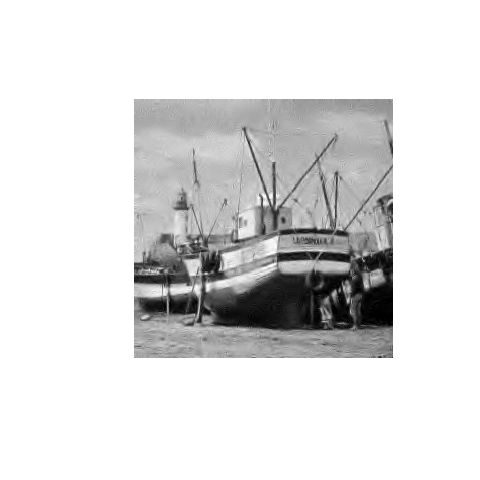

In [40]:
T <- 1.25*sigma

options(repr.plot.width=4, repr.plot.height=4)
source("nt_toolbox/perform_wavelet_transf.R")
imageplot(clamp(ThreshWav(f, T)))

__Exercise 4__

Display the evolution of the denoising SNR when $T$ varies.
Store the optimal denoising result in $f_{TI}$.

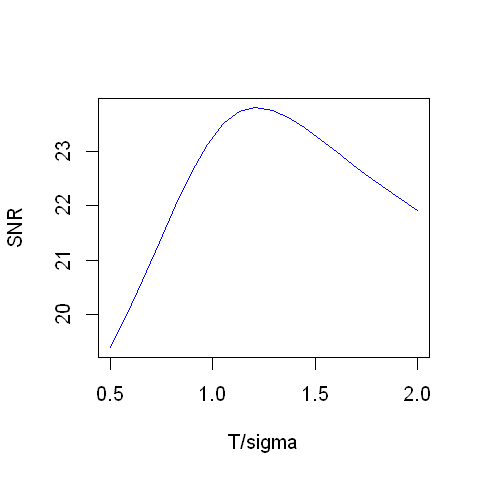

In [41]:
options(repr.plot.width=4, repr.plot.height=4)

source("nt_solutions/denoisingwav_4_block/exo4.R")

In [42]:
## Insert your code here.

Display the result.

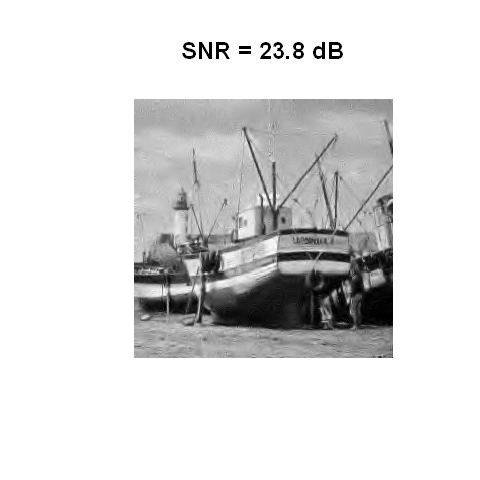

In [43]:
imageplot(clamp(fTI), paste("SNR =", round(snr(f0, fTI),1), "dB"))

Bibliography
------------
<html><a name="biblio"></a></html>


* [CaiSil01] T. Cai and B.W. Silverman, [Incorporating information on neighboring coefficients into wavelet estimation][1], Sankhya 63, 127-148, 2001.
* [Cai99] T. Cai, [Adaptive wavelet estimation: a block thresholding and oracle inequality approach][2], The Annals of Statistics 27, 898-924, 1999.
* [HallKerkPic99] P. Hall, G. Kerkyacharian and D. Picard, _On the minimax optimality of block thresholded wavelet estimator_, Statistica Sinica 9(1999), 33-49

[1]:http://sankhya.isical.ac.in/search/63b2/caifnl.html
[2]:http://dx.doi.org/10.1214/aos/1018031262